In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import preprocess
import group_calc
import factor_analysis
import backtest
import utils

# 载入数据

In [2]:
factor_df=pd.read_csv('./data/factor_df.csv')
ret_df=pd.read_csv('./data/ret_df.csv')
mktmv_df = pd.read_csv('./data/mktmv_df.csv')
ind_df=pd.read_csv('./data/ind_df.csv')
codefunc1=lambda x: '{:0>6}'.format(x)
factor_df['stock_code']=factor_df['stock_code'].apply(codefunc1)
ret_df['stock_code']=ret_df['stock_code'].apply(codefunc1)
mktmv_df['stock_code']=mktmv_df['stock_code'].apply(codefunc1)
ind_df['stock_code']=ind_df['stock_code'].apply(codefunc1)
codefunc2 = lambda x: x if np.isnan(x) else str(int(x))
factor_df['trade_date']=factor_df['trade_date'].apply(codefunc2)
ret_df['trade_date']=ret_df['trade_date'].apply(codefunc2)
mktmv_df['trade_date']=mktmv_df['trade_date'].apply(codefunc2)
ind_df['trade_date']=ind_df['trade_date'].apply(codefunc2)
ind_df

,trade_date,stock_code,ind_code
0,20080104,000001,银行
1,20080104,000002,房地产
2,20080104,000003,综合
3,20080104,000004,房地产
4,20080104,000005,房地产
...,...,...,...
1069697,20170120,603993,有色金属
1069698,20170120,603996,家用电器
1069699,20170120,603997,汽车
1069700,20170120,603998,医药生物


# 预处理

In [3]:
# MAD去极值
factor_df = preprocess.del_outlier(factor_df, 'factor', method='mad', n=3)
# 排序标准化
factor_df = preprocess.standardize(factor_df, 'factor', method='rank')
# 同时做市值中性化和行业中性化
factor_df=preprocess.neutralize(factor_df=factor_df,
                                factor_name='factor',
                                mktmv_df=mktmv_df,
                                industry_df=ind_df)
factor_df

,trade_date,stock_code,factor
0,20080104,000002,-0.040872
1,20080104,000006,1.589924
2,20080104,000009,-1.025871
3,20080104,000011,0.629100
4,20080104,000012,0.183585
...,...,...,...
739903,20170120,603866,-0.240657
739904,20170120,603868,-0.998986
739905,20170120,603883,-0.180011
739906,20170120,603993,-0.306875


# 分组收益率计算

In [4]:
group_ret = group_calc.get_group_ret(factor_df, ret_df, 'factor', 5, mktmv_df)
group_ret

,group0,group1,group2,group3,group4,factor_ret
20080111,0.018571,0.014793,0.030236,0.027265,0.027169,0.008598
20080118,-0.065159,-0.058937,-0.107270,-0.092724,-0.094238,-0.029079
20080125,-0.046205,-0.077966,-0.081876,-0.077598,-0.089817,-0.043612
20080201,0.011683,0.010209,0.058022,0.044810,0.048214,0.036531
20080205,0.035954,0.012898,0.007038,0.021103,0.018551,-0.017403
...,...,...,...,...,...,...
20161223,0.007796,0.003445,-0.003823,-0.000395,0.011339,0.003543
20161230,0.000129,0.008069,0.009892,0.005794,0.001033,0.000904
20170106,0.006840,0.014359,0.009899,0.015968,0.017669,0.010828
20170113,-0.067041,-0.038342,-0.032717,-0.047220,-0.039948,0.027093


# 因子分析

In [5]:
factor_analysis.newy_west_test(group_ret['factor_ret'],'factor')

{'factor_name': ['factor'],
 'ret_mean(%)': [0.373],
 't-value': [3.396],
 'p-value': [0.001],
 'p-star': ['***']}

# IC计算

In [6]:
ic_df=factor_analysis.get_factor_ic(factor_df, ret_df, 'factor')
print(ic_df['ic'].mean())
ic_df

0.038132239483626894


,ic
trade_date,
20080111,0.028366
20080118,-0.034504
20080125,-0.075528
20080201,0.216214
20080205,-0.097220
...,...
20161223,0.121549
20161230,0.000591
20170106,0.046733


# 净值曲线

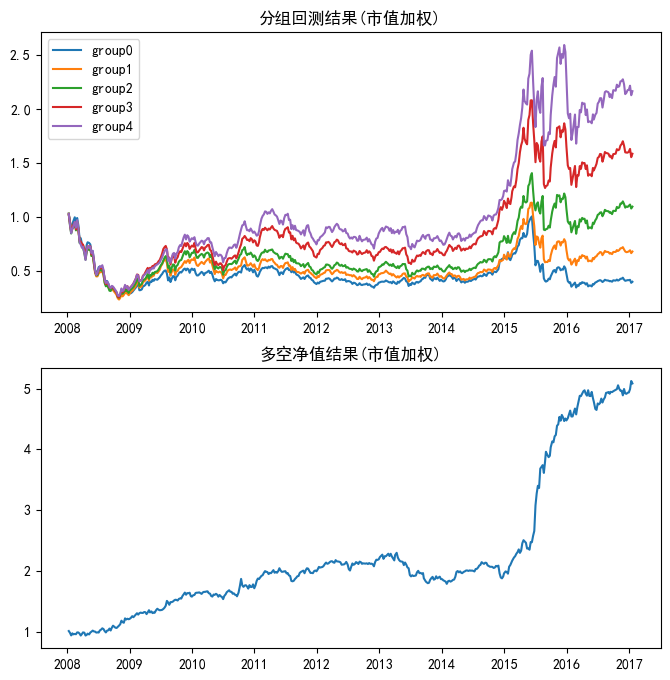

In [7]:
group_ret.index=pd.to_datetime(group_ret.index)
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
for i in range(5):
    col = 'group'+str(i)
    tempret = group_ret.loc[:,col].copy()
    nv = backtest.net_value(tempret)
    plt.plot(tempret.index, nv,label='group'+str(i))
plt.legend()
plt.title('分组回测结果(市值加权)')
plt.subplot(2,1,2)
factor_nv = backtest.net_value(group_ret.loc[:,'factor_ret'])
plt.plot(group_ret.index, factor_nv)
plt.title('多空净值结果(市值加权)')
plt.show()

# 分组回测指标

In [8]:
factor_analysis.get_group_ret_analysis(group_ret, period='WEEKLY')

,group0,group1,group2,group3,group4,factor_ret
ann_ret,-9.879961,-4.286241,1.015287,5.313107,9.071960,20.047261
ann_vol,34.765417,34.637323,35.100249,35.052240,35.885235,15.060466
ann_sp,-0.284189,-0.123746,0.028925,0.151577,0.252805,1.331118
mdd,-76.026270,-77.254906,-75.869261,-75.508493,-74.339324,-22.259664
